##### In Gaussian Discriminant Analysis we try to model p(x|y) and p(y) as oppose to p(y|x) we did earlier, it’s called Generative Learning Algorithms. Once we learn the model p(y) and p(x|y) using training set, we use Bayes Rule to derive the p(y|x) as

$p(y | x)=\frac{p(x | y) p(y)}{p(x)}$

##### we assume p(x|y) is distributed according to a multivariate normal distribution and p(y) is distributed according to Bernoulli. So the model is

$\begin{aligned} p(y) &=\phi^{y}(1-\phi)^{(1-y)} \\ p(x | y=0) &=\frac{1}{(2 \pi)^{n / 2}\left|\sum\right|^{\frac{1}{2}}} \exp \left(-\frac{1}{2}\left(x-\mu_{0}\right)^{T} \sum_{-1}^{-1}\left(x-\mu_{0}\right)\right) \\ p(x | y=1) &=\frac{1}{(2 \pi)^{n / 2}\left|\sum\right|^{\frac{1}{2}}} \exp \left(-\frac{1}{2}\left(x-\mu_{1}\right)^{T} \sum^{-1}\left(x-\mu_{1}\right)\right) \end{aligned}$

#### Basic Equations for finding model parameters for GDA

We can derive this equation by simply equating the derivative of log likelihood to zero in order to maximize likelihood

\begin{aligned} \phi &=\frac{1}{m} \sum_{i=1}^{m} 1\left\{y^{(i)}=1\right\} \\ \mu_{0} &=\frac{\sum_{i=1}^{m} 1\left\{y^{(i)}=0\right\} x^{(i)}}{\sum_{i=1}^{m} 1\left\{y^{(i)}=0\right\}} \\ \mu_{1} &=\frac{\sum_{i=1}^{m} 1\left\{y^{(i)}=1\right\} x^{(i)}}{\sum_{i=1}^{m} 1\left\{y^{(i)}=1\right\}} \\ \sum &=\frac{1}{m} \sum_{i=1}^{m}\left(x^{(i)}-\mu_{k}\right)\left(x^{(i)}-\mu_{k}\right)^{T} \text { where } k=1\left\{y^{(i)}=1\right\} \end{aligned}

In [1]:
#import necessary libraries

import math

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [52]:
def calculate_phi(y):
    """
        calculates phi according to derived formulae 
        \phi=\frac{1}{m} \sum_{i=1}^{m} 1\left\{y^{(i)}=1\right\}
    """
    y_1 = y.sum()
    
    return y_1/len(y)

In [3]:
def calculate_mu0(X,y):
    """
        calculates mean vector for negative class conditional distribution 
        according to derived formulae \mu_{0}=\frac{\sum_{i=1}^{m} 1\left\{y^{(i)}=0\right\} x^{(i)}}
        {\sum_{i=1}^{m} 1\left\{y^{(i)}=0\right\}}
    """
    mu_0 = np.zeros(X.shape[1])
    
    for xi,yi in zip(X,y):
        mu_0 += xi*(1 if yi == 0 else 0)
    y_0 = (y==0).sum()
    
    mu_0 /= y_0
    
    return mu_0

In [53]:
def calculate_mu1(X,y):
    """
        calculates mean vector for positive class conditional distribution 
        according to derived formulae \mu_{1}=\frac{\sum_{i=1}^{m} 1\left\{y^{(i)}=1\right\} x^{(i)}}
        {\sum_{i=1}^{m} 1\left\{y^{(i)}=1\right\}}
    """
    mu_1 = np.zeros(X.shape[1])
    
    for xi,yi in zip(X,y):
        mu_1 += xi*(1 if yi == 1 else 0)
    y_1 = y.sum()
    
    mu_1 /= y_1
    
    return mu_1

In [54]:
def calculate_covariance(X, y, mu_0, mu_1):
    """
        calculates covariance matrix according to
        derived formulae \sum=\frac{1}{m} \sum_{i=1}^{m}\left(x^{(i)}-\mu_{k}\right)\left(x^{(i)}-\mu_{k}
        \right)^{T} \text { where } k=1\left\{y^{(i)}=1\right\}
    """
    mu_0 = mu_0.reshape(mu_0.shape[0],-1)
    mu_1 = mu_1.reshape(mu_1.shape[0],-1)
    
    sigma = np.zeros([X.shape[1],X.shape[1]])
    
    for xi,yi in zip(X,y):
        mu = mu_0 if yi==0 else mu_1
        xi = xi.reshape(xi.shape[0],-1)
        sigma += np.matmul((xi - mu),(xi-mu).T)
        
    sigma /= len(y)
    
    return sigma

Log likelihood = $\log \prod_{i=1}^{m} p\left(x | y ; \phi, \mu_{k}, \sum\right) p(y ; \phi)$
               = $\log \prod_{i=1}^{m}\left(\frac{1}{(2 \pi)^{n / 2}\left|\sum\right|^{\frac{1}{2}}} \exp \left(-\frac{1}{2}\left(x-\mu_{k}\right)^{T} \sum^{-1}\left(x-\mu_{k}\right)\right)\right) \cdot \phi^{y}(1-\phi)^{(1-y)}$

After simplification we get 

Log likelihood = $\sum_{i=1}^{m}\left[-\frac{n}{2} \log 2 \pi-\frac{1}{2} \log \left|\sum\right|-\frac{1}{2}(x-\mu)^{T} \sum^{-1}(x-\mu)+y \log \phi+(1-y) \log (1-\phi)\right]$

In [55]:
def net_log_prob(x, mu_0, mu_1, sigma, phi):
    """
        Taking difference of log likelihood for postive and negative class i.e LL(x=1) - LL(x=0)
    """
    lognormal1 = np.float64(((x - mu_1).T @ sigma.I @ (x - mu_1)) / 2)
    lognormal0 = np.float64(((x - mu_0).T @ sigma.I @ (x - mu_0)) / 2)
    logbinomial = np.log(phi / (1-phi))

    return lognormal0 - lognormal1 + logbinomial

In [56]:
def plot_decision_boundary(mu_0, mu_1, sigma, phi, ax, fill=False):
    """
        Plot decision boundary of model upto first level
        Note: change fill to true for continous contour map
    """
    x1 = np.linspace(-xmax, xmax, 100)
    x2 = np.linspace(-xmax, xmax, 100)
    x1, x2 = np.meshgrid(x1, x2)

    z = np.zeros(x1.shape)

    mu_0 = mu_0.reshape(mu_0.shape[0], -1)
    mu_1 = mu_1.reshape(mu_1.shape[0], -1)
    sigma = np.matrix(sigma)

    for i in range(0, len(z)):
        for j in range(0, len(z[0])):
            x = np.array([x1[i][j], x2[i][j]]).reshape(2, -1)
            z[i][j] = net_log_prob(x, mu_0, mu_1, sigma, phi)
    if not fill:
        bx = ax.contour(x1, x2, z, levels=[0])
    else:
        bx = ax.contourf(x1, x2, z)
        plt.colorbar(bx)
    return bx

In [57]:
def scatterplot(X, y):
    """
        Plot datapoints
    """
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('Scatter Plot and decision boundary')

    xone = X[:, 0]
    xtwo = X[:, 1]

    xone_yis1 = []
    xtwo_yis1 = []

    xone_yis0 = []
    xtwo_yis0 = []

    for x1, x2, y in zip(xone, xtwo, y):
        if y == 1:
            xone_yis1.append(x1)
            xtwo_yis1.append(x2)
        else:
            xone_yis0.append(x1)
            xtwo_yis0.append(x2)

    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.xlim((-math.ceil(xmax), math.ceil(xmax)))
    plt.ylim((-math.ceil(xmax), math.ceil(xmax)))

    y0 = plt.scatter(xone_yis0, xtwo_yis0, marker='o')
    y1 = plt.scatter(xone_yis1, xtwo_yis1, marker='x')
    ax.legend([y0, y1], ['Negative', 'Positive'])

    return ax

In [5]:
# Generate Dataset
X, y = make_classification(n_samples=120,n_features=2, n_redundant=0, n_informative=2,
                           random_state=69, n_clusters_per_class=1)

In [24]:
# Define maximum value of our dataset
global xmax 
xmax= X.max()

In [6]:
# Split Dataset into trainin and testing
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state = 100)

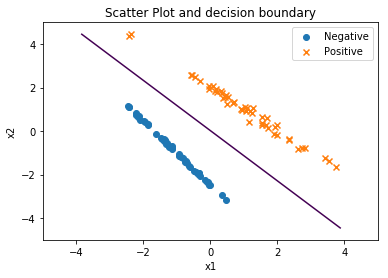

In [49]:
# Calculate model parameters and plot decision boundary
fig = plt.figure()
ax = scatterplot(Xtrain, ytrain)

Phi = calculate_phi(ytrain)
mu_0 = calculate_mu0(Xtrain,ytrain)
mu_1 = calculate_mu1(Xtrain,ytrain)
Sigma = calculate_covariance(Xtrain, ytrain, mu_0, mu_1)
bx = plot_decision_boundary(mu_0, mu_1, Sigma, Phi, ax, fill = False)
plt.show()

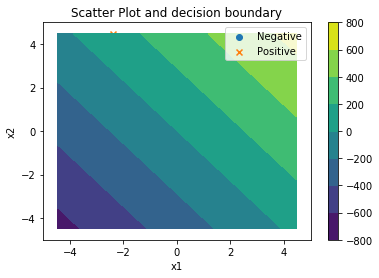

In [51]:
# plot continous contour map
fig = plt.figure()
ax = scatterplot(Xtrain, ytrain)
bx = plot_decision_boundary(mu_0, mu_1, Sigma, Phi, ax, fill = True)
plt.show()

In [67]:
def predict(Xtest):
    """
        Predict on test dataset
    """
    raw_scores = np.zeros([Xtest.shape[0]])
    
    for i,x in enumerate(Xtest):
        raw_scores[i] = net_log_prob(x, mu_0, mu_1, np.matrix(Sigma), Phi)
    
    return np.where(raw_scores>0,1,0)

In [72]:
ypred = predict(Xtest)

In [59]:
# calculate accuracy on test dataset
print("Our Gaussian Discriminant Analysis model has an accuracy of {} %".format(accuracy_score(ypred, ytest)*100))

Our Gaussian Discriminant Analysis model has an accuracy of 95.83333333333334 %


In [60]:
# Class for Gaussian Discriminant analysis model
class GDA():
    
    def __init__(self):
        self.mu_0 = None
        self.mu_1 = None
        self.sigma = None
        self.phi = None
        self.X = None
        self.y = None
    @staticmethod    
    def calculate_phi(y):
    
        y_1 = y.sum()

        return y_1/len(y)
    @staticmethod
    def calculate_mu0(X,y):
    
        mu_0 = np.zeros(X.shape[1])

        for xi,yi in zip(X,y):
            mu_0 += xi*(1 if yi == 0 else 0)
        y_0 = (y==0).sum()

        mu_0 /= y_0

        return mu_0
    @staticmethod
    def calculate_mu1(X,y):
    
        mu_1 = np.zeros(X.shape[1])

        for xi,yi in zip(X,y):
            mu_1 += xi*(1 if yi == 1 else 0)
        y_1 = y.sum()

        mu_1 /= y_1

        return mu_1
    @staticmethod
    def calculate_covariance(X, y, mu_0, mu_1):
    
        mu_0 = mu_0.reshape(mu_0.shape[0],-1)
        mu_1 = mu_1.reshape(mu_1.shape[0],-1)

        sigma = np.zeros([X.shape[1],X.shape[1]])

        for xi,yi in zip(X,y):
            mu = mu_0 if yi==0 else mu_1
            xi = xi.reshape(xi.shape[0],-1)
            sigma += np.matmul((xi - mu),(xi-mu).T)

        sigma /= len(y)

        return sigma
    @staticmethod
    def net_log_prob(x, mu_0, mu_1, sigma, phi):
    
        lognormal1 = np.float64(((x - mu_1).T @ sigma.I @ (x - mu_1)) / 2)
        lognormal0 = np.float64(((x - mu_0).T @ sigma.I @ (x - mu_0)) / 2)
        logbinomial = np.log(phi / (1-phi))

        return lognormal0 - lognormal1 + logbinomial

    def fit(self, X, y):
        
        self.X = X
        self.y = y
        self.mu_0 = GDA.calculate_mu0(X,y)
        self.mu_1 = GDA.calculate_mu1(X,y)
        self.sigma = GDA.calculate_covariance(X, y, self.mu_0, self.mu_1)
        self.phi = GDA.calculate_phi(y)
    
    def scatterplot(self):
        
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.set_title('Scatter Plot and Decision boundary')

        xone = self.X[:, 0]
        xtwo = self.X[:, 1]

        xone_yis1 = []
        xtwo_yis1 = []

        xone_yis0 = []
        xtwo_yis0 = []

        for x1, x2, y in zip(xone, xtwo, self.y):
            if y == 1:
                xone_yis1.append(x1)
                xtwo_yis1.append(x2)
            else:
                xone_yis0.append(x1)
                xtwo_yis0.append(x2)

        plt.xlabel("x1")
        plt.ylabel("x2")
        xmax= self.X.max()
        plt.xlim((-math.ceil(xmax), math.ceil(xmax)))
        plt.ylim((-math.ceil(xmax), math.ceil(xmax)))

        y0 = plt.scatter(xone_yis0, xtwo_yis0, marker='o')
        y1 = plt.scatter(xone_yis1, xtwo_yis1, marker='x')
        ax.legend([y0, y1], ['Negative', 'Positive'])

        return ax
    
    def plot_decision_boundary(self, fill = False):
        
        ax = self.scatterplot()
        xmax= self.X.max()
        x1 = np.linspace(-xmax, xmax, 100)
        x2 = np.linspace(-xmax, xmax, 100)
        x1, x2 = np.meshgrid(x1, x2)

        z = np.zeros(x1.shape)

        mu_0 = self.mu_0.reshape(self.mu_0.shape[0], -1)
        mu_1 = self.mu_1.reshape(self.mu_1.shape[0], -1)
        sigma = np.matrix(self.sigma)

        for i in range(0, len(z)):
            for j in range(0, len(z[0])):
                x = np.array([x1[i][j], x2[i][j]]).reshape(2, -1)
                z[i][j] = GDA.net_log_prob(x, mu_0, mu_1, sigma, self.phi)
        if not fill:
            bx = ax.contour(x1, x2, z, levels=[0])
        else:
            bx = ax.contourf(x1, x2, z)
            plt.colorbar(bx)
        plt.show()
        return
    
    def predict(self, Xtest):
        raw_scores = np.zeros([Xtest.shape[0],])
        
        mu_0 = self.mu_0.reshape(self.mu_0.shape[0], -1)
        mu_1 = self.mu_1.reshape(self.mu_1.shape[0], -1)
        sigma = np.matrix(self.sigma)
        
        for i,x in enumerate(Xtest):
            raw_scores[i] = GDA.net_log_prob(x.reshape(x.shape[0],-1), mu_0, mu_1, sigma, self.phi)

        return np.where(raw_scores>0,1,0)

In [49]:
gda = GDA()

In [50]:
gda.fit(Xtrain,ytrain)

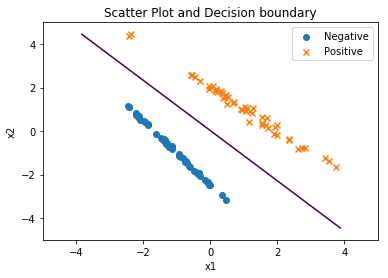

In [51]:
gda.plot_decision_boundary()

In [41]:
ypred = gda.predict(Xtest)

In [43]:
accuracy_score(ypred, ytest)*100

95.83333333333334